# Import the Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# download the data from google drive and unzip 
!gdown https://drive.google.com/uc?id=1OYcrdW8VdQrNQ-P0d8UotHx5QmY7TQaY
!unzip 'previous material.zip'

Downloading...
From: https://drive.google.com/uc?id=1OYcrdW8VdQrNQ-P0d8UotHx5QmY7TQaY
To: /content/previous material.zip
73.1MB [00:00, 119MB/s] 
Archive:  previous material.zip
replace Taylor_lyrics.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import nltk
nltk.download('averaged_perceptron_tagger') 
import nltk
nltk.download('wordnet')
nltk.download('punkt') 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from pywsd.utils import lemmatize_sentence
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from sklearn.feature_extraction.text import TfidfVectorizer
import pronouncing
import syllables
import string
lmm = WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

import re
import random
import markovify
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
# import the dataset of taylor swift lyrics
dataset = pd.read_csv('data/taylor_swift_lyrics.csv', encoding='latin1')
dataset.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [0]:
# take a quick look at the data (albums, song names, total number of song)
print(dataset['album'].unique())
print(dataset['track_title'].unique())
print(dataset['track_title'].unique().size)

['Taylor Swift' 'Fearless' 'Speak Now' 'Red' '1989' 'reputation']
['Tim McGraw' 'Picture To Burn' 'Teardrops On My Guitar'
 'A Place In This World' 'Cold as You' 'The Outside'
 'Tied Together With A Smile' 'Stay Beautiful' "Should've Said No"
 "Mary's Song (Oh My My My)" 'Our Song' "I'm Only Me When I'm With You"
 'Invisible' 'A Perfectly Good Heart' 'Fearless' 'Fifteen' 'Love Story'
 'Hey Stephen' 'White Horse' 'You Belong With Me'
 'Breathe (Ft.\xa0Colbie\xa0Caillat)' 'Tell Me Why' "You're Not Sorry"
 'The Way I Loved You' 'Forever & Always' 'The Best Day' 'Change' 'Mine'
 'Sparks Fly' 'Back To December' 'Speak Now' 'Dear John' 'Mean'
 'The Story of Us' 'Never Grow Up' 'Enchanted' 'Better Than Revenge'
 'Innocent' 'Haunted' 'Last Kiss' 'Long Live' 'Ours' 'If This Was a Movie'
 'Superman' 'State of Grace' 'Red' 'Treacherous' 'I Knew You Were Trouble'
 'All Too Well' '22' 'I Almost Do'
 'We Are Never Ever Getting Back Together' 'Stay Stay Stay'
 'The Last Time (Ft.\xa0Gary\xa0Lightbody

In [0]:
# overlook of the grouped data
dataset.groupby(by=['album','track_title']).first()

artist  ...  year
album      track_title                                          ...      
1989       All You Had to Do Was Stay             Taylor Swift  ...  2014
           Bad Blood                              Taylor Swift  ...  2014
           Blank Space                            Taylor Swift  ...  2014
           Clean                                  Taylor Swift  ...  2014
           How You Get The Girl                   Taylor Swift  ...  2014
...                                                        ...  ...   ...
reputation King of My Heart                       Taylor Swift  ...  2017
           Look What You Made Me Do               Taylor Swift  ...  2017
           New Year's Day                         Taylor Swift  ...  2017
           So It Goes...                          Taylor Swift  ...  2017
           This Is Why We Can't Have Nice Things  Taylor Swift  ...  2017

[94 rows x 5 columns]

## Use dataframe to preprocess data

In [0]:
# sort out all songs & merge lyrics from the same song
merged_dataset = dataset.groupby(by=['track_title'])['lyric'].agg(lambda x: '. '.join(x))
merged_dataset = pd.DataFrame(merged_dataset).reset_index()
merged_dataset.head(10)

,track_title,lyric
0,...Ready for It?,Knew he was a killer first time that I saw him...
1,22,It feels like a perfect night to dress up like...
2,A Perfectly Good Heart,Why would you wanna break a perfectly good hea...
3,A Place In This World,"I don't know what I want, so don't ask me. Cau..."
4,All Too Well,"I walked through the door with you, the air wa..."
5,All You Had to Do Was Stay,People like you always want back. The love the...
6,Back To December,I'm so glad you made time to see me. How's lif...
7,Bad Blood,"'Cause baby, now we've got bad blood. You know..."
8,Begin Again,Took a deep breath in the mirror. He didn't li...
9,Better Than Revenge,Now go stand in the corner and think about wha...


In [0]:
def preprocess(lyric):
  ''' Get rid of punctuations & Convert all text to lowercase. '''
  punctuations = "~`!@#$%^&*()_+-=[]\\{}|;:'\",./<>?0123456789"
  def remove_punc(text):
    for p in punctuations:
      text = text.replace(p,'')
    return text

  lyric = remove_punc(lyric).lower()
  return lyric

In [0]:
# preprocess the lyrics to raw_text
merged_dataset['lyric'] = merged_dataset['lyric'].apply(lambda x: preprocess(x))
raw_text = '\n'.join(merged_dataset['lyric'].values)

# LSTM Model to Produce Lyrics

## Feed characters into the model

In [0]:
# mapping chars to ints:
chars = sorted(list(set(raw_text)))
int_chars = dict((i,c) for i,c in enumerate(chars))
chars_int = dict((c,i) for i,c in enumerate(chars))

num_chars = len(raw_text)
num_vocab = len(chars)
print('number of all characters in lyricstext: ', num_chars)
print('number of unique characters (features): ', num_vocab)

number of all characters in lyricstext:  167834
number of unique characters (features):  34


In [0]:
# preprocess the dataset
seq_len = 100
num_data = len(raw_text) - seq_len
X, Y = np.zeros([num_data, seq_len, 1]), np.zeros([num_data])

for i in range(num_data):
  # input sequence as samples
  seq_in = raw_text[i:i+seq_len]
  # output sequence as target
  seq_out = raw_text[i+seq_len]
  # store samples in X
  X[i,:,:] = np.reshape([chars_int[idx] for idx in seq_in], (seq_len, 1)) 
  # store targets in y
  Y[i] = np.array(chars_int[seq_out])

# one hot encode the output target
#Y = np_utils.to_categorical(Y)

print('total number of data: ', num_data)

total number of data:  167734


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05)
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).long())
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [0]:
print(X.shape)
print(X_train.shape)
print(Y_train.shape)

(167734, 100, 1)
(159347, 100, 1)
(159347,)


In [0]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, batch_size, output_dim, num_layers):
    super(LSTM, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim 
    self.batch_size = batch_size
    self.output_dim = output_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout=0.2)
    self.fc = nn.Linear(self.hidden_dim, self.output_dim)

  def forward(self, x):
    x = x.view(-1, self.batch_size, self.input_dim)
    output, hidden = self.lstm(x)
    hidden = hidden[0] + hidden[1]
    fc_output = self.fc(hidden)
    prediction = fc_output[0] + fc_output[1]
    return prediction

In [0]:
lr = 0.001
epochs = 30
input_dim, hidden_dim, output_dim, num_layers = seq_len, 256, num_vocab, 4

In [0]:
model = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [0]:
training_loss = np.zeros(epochs)

for epoch in range(epochs):
  Loss = 0
  total = 0
  step = 0
  for i,(x,y) in enumerate(train_loader):
    if x.shape[0] != batch_size: break

    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output.permute(0,1), y)
    loss.backward()
    optimizer.step()

    Loss += loss.item()
    total += y.size(0)
    step += 1

    if step % 100 == 0:
      print('Step|Epoch: [{}|{}], Training loss: {:.4f}'.format(step, epoch+1, loss.item()))
  training_loss[epoch] = Loss/total 

Step|Epoch: [100|1], Training loss: 2.6992
Step|Epoch: [200|1], Training loss: 2.6612
Step|Epoch: [300|1], Training loss: 2.6924
Step|Epoch: [400|1], Training loss: 2.8477
Step|Epoch: [500|1], Training loss: 2.7216
Step|Epoch: [600|1], Training loss: 2.5235
Step|Epoch: [700|1], Training loss: 2.5342
Step|Epoch: [800|1], Training loss: 2.6833
Step|Epoch: [900|1], Training loss: 2.7329
Step|Epoch: [1000|1], Training loss: 2.5714
Step|Epoch: [1100|1], Training loss: 2.5006
Step|Epoch: [1200|1], Training loss: 2.5645
Step|Epoch: [100|2], Training loss: 2.4702
Step|Epoch: [200|2], Training loss: 2.6146
Step|Epoch: [300|2], Training loss: 2.5524
Step|Epoch: [400|2], Training loss: 2.5089
Step|Epoch: [500|2], Training loss: 2.4969
Step|Epoch: [600|2], Training loss: 2.5666
Step|Epoch: [700|2], Training loss: 2.4713
Step|Epoch: [800|2], Training loss: 2.6700
Step|Epoch: [900|2], Training loss: 2.4590
Step|Epoch: [1000|2], Training loss: 2.2748
Step|Epoch: [1100|2], Training loss: 2.3113
Step|E

In [0]:
torch.save(model.state_dict(), './model1')

In [0]:
# input_dim, hidden_dim, batch_size, output_dim, num_layers = seq_len, 256, 1, num_vocab, 4
model1 = LSTM(100, 256, 1, 34, 4)
model1.load_state_dict(torch.load('./model1'))
model1.eval()

LSTM(
  (lstm): LSTM(100, 256, num_layers=4, dropout=0.2)
  (fc): Linear(in_features=256, out_features=34, bias=True)
)

In [0]:
idx = np.random.randint(0, len(X))
ints = X[idx].tolist()
seed = ''.join(int_chars[i[0]] for i in ints)
print(f'Seed: {seed}')

Seed: i had to lose come back come back come back to me like you would you would if this was a movie stand


In [0]:
generated_chars = 300
res = ''
for i in range(generated_chars):
  x = np.reshape(ints, (1, len(ints), 1))
  x = torch.from_numpy(x).float()

  output = model1(x)
  _,predict = torch.max(output.data, 1)
  index = predict.data.cpu().tolist()
  res += int_chars[index[0]]

  ints.append(index)
  ints = ints[1:len(ints)]

print('generated lyrics:\n')
res

generated lyrics:



' i wou wou and i was and to the to to the firs the tay i koow that you wou a be to the you i dor the pood im me doun wou i dould and i wou le and iaue to i want she it to to to the tane dont tane your i wou that i sane and to the tane it i wanne i wour and i hare to to to the le tale to to to to tha'

## Feed words into the model

In [0]:
# mapping words to ints:
words = sorted(set(raw_text.split()))
int_words = dict((i,c) for i,c in enumerate(words))
words_int = dict((c,i) for i,c in enumerate(words))
raw_text_words = raw_text.split()

num_words = len(raw_text_words)
num_vocab = len(words)
print('number of all words in lyricstext: ', num_words)
print('number of unique words (features): ', num_vocab)

number of all words in lyricstext:  35202
number of unique words (features):  2393


In [0]:
# embed the dataset
seq_len = 10
num_data = len(raw_text_words) - seq_len
X, Y = np.zeros([num_data, seq_len]), np.zeros([num_data])

for i in range(num_data):
  # input sequence as samples
  seq_in = raw_text_words[i:i+seq_len]
  # output sequence as target
  seq_out = raw_text_words[i+seq_len]
  # store samples in X
  X[i,:] = np.reshape([words_int[idx] for idx in seq_in], (seq_len)) 
  # store targets in y
  Y[i] = np.array(words_int[seq_out])

print('total number of data: ', num_data)

total number of data:  35192


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05)
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).long())
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [0]:
print(X.shape)
print(X_train.shape)
print(Y_train.shape)

(35192, 10)
(33432, 10)
(33432,)


In [0]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, batch_size, output_dim, num_layers):
    super(LSTM, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim 
    self.batch_size = batch_size
    self.output_dim = output_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout=0.2)
    self.fc = nn.Linear(self.hidden_dim, self.output_dim)

  def forward(self, x):
    x = x.view(-1, self.batch_size, self.input_dim)
    output, hidden = self.lstm(x)
    hidden = hidden[0] + hidden[1]
    fc_output = self.fc(hidden)
    prediction = fc_output[0] + fc_output[1]
    return prediction

In [0]:
lr = 0.001
epochs = 50
input_dim, hidden_dim, output_dim, num_layers = seq_len, 256, num_vocab, 4

In [0]:
model = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [0]:
training_loss = np.zeros(epochs)

for epoch in range(epochs):
  Loss = 0
  total = 0
  step = 0
  for i,(x,y) in enumerate(train_loader):
    if x.shape[0] != batch_size: break
    optimizer.zero_grad()

    output = model(x)
    loss = criterion(output.permute(0,1), y)
    loss.backward()
    optimizer.step()

    Loss += loss.item()
    total += y.size(0)
    step += 1

    if step % 100 == 0:
      print('Step|Epoch: [{}|{}], Training loss: {:.4f}'.format(step, epoch+1, loss.item()))
  training_loss[epoch] = Loss/total 

Step|Epoch: [100|1], Training loss: 6.1124
Step|Epoch: [200|1], Training loss: 5.9417
Step|Epoch: [300|1], Training loss: 5.9070
Step|Epoch: [400|1], Training loss: 5.9867
Step|Epoch: [500|1], Training loss: 5.8795
Step|Epoch: [100|2], Training loss: 5.3397
Step|Epoch: [200|2], Training loss: 6.3943
Step|Epoch: [300|2], Training loss: 6.0920
Step|Epoch: [400|2], Training loss: 5.7918
Step|Epoch: [500|2], Training loss: 5.7030
Step|Epoch: [100|3], Training loss: 6.1490
Step|Epoch: [200|3], Training loss: 5.7549
Step|Epoch: [300|3], Training loss: 5.7802
Step|Epoch: [400|3], Training loss: 5.6017
Step|Epoch: [500|3], Training loss: 5.6080
Step|Epoch: [100|4], Training loss: 5.2855
Step|Epoch: [200|4], Training loss: 5.1540
Step|Epoch: [300|4], Training loss: 5.9575
Step|Epoch: [400|4], Training loss: 6.1728
Step|Epoch: [500|4], Training loss: 5.5076
Step|Epoch: [100|5], Training loss: 5.3386
Step|Epoch: [200|5], Training loss: 5.3302
Step|Epoch: [300|5], Training loss: 5.3321
Step|Epoch:

In [0]:
torch.save(model.state_dict(), './model1')

In [0]:
# input_dim, hidden_dim, batch_size, output_dim, num_layers = seq_len, 256, 1, num_vocab, 4
model1 = LSTM(seq_len, 256, 1, num_vocab, 4)
model1.load_state_dict(torch.load('./model1'))
model1.eval()

LSTM(
  (lstm): LSTM(10, 256, num_layers=4, dropout=0.2)
  (fc): Linear(in_features=256, out_features=2393, bias=True)
)

In [0]:
def generate_word(ints, num_words):
  idx_list, res_list = [], []
  for i in range(num_words):
    x = np.reshape(ints, (1, len(ints), 1))
    x = torch.from_numpy(x).float()

    output = model1(x)
    _,predict = torch.max(output.data, 1)
    index = predict.data.cpu().tolist()
    idx_list.append(index[0])
    res_list.append(int_words[index[0]])
    # print(f'Iteration:{i}, Index:{index}, Results:{int_words[index[0]]}')
    ints += index
    ints = ints[1:len(ints)]

  res = ' '.join(w for w in res_list)
  return res, idx_list

### Given one input sentence, use predicted sentence as input to generate next one

In [0]:
# initialize the input values
idx = np.random.randint(0, len(X))
ints = X[idx].tolist()

# print the input context
seed = ' '.join(int_words[i] for i in ints)
print(f'Seed: {seed}')

Seed: i wish you would i wish you would i wish


In [0]:
inputs, outputs = [], []
sentence_size = np.random.randint(10, 12, size=20).tolist()
for size in sentence_size:  
  res, output = generate_word(ints, size)
  inputs += [' '.join(int_words[i] for i in ints)]
  outputs += [res]
  ints = output[-10:]

print('generated lyrics:\n') 
outputs

### Given all input sentences, predict the next ones

In [0]:
# initialize the input values
idx = np.random.randint(0, len(X), size=20)
ints = X[idx].tolist()

inputs, outputs = [], []
sentence_size = np.random.randint(10, 12, size=20).tolist()
for l,size in zip(ints,sentence_size): 
  res, output = generate_word(l, size)
  inputs += [' '.join(int_words[i] for i in l)]
  outputs += [res]

print('generated lyrics:\n') 
outputs

generated lyrics:



['lip me out the i you you keeps whatcha shake',
 'finally dangerous and by prince you is the you for all',
 'rudely barging of somehow you this other it chair fight unresolved',
 'dear john killing heart ohsoeasy know so drug wearing sixteen',
 'drew needed up you doin sing prince do anticipation i',
 'you all write out of the woods yet are we out',
 'leaves and beach the so memory paper lying thing tshirts',
 'fragile ey given you arms doin juliet another now nikes and',
 'you were right here right steps you you let me',
 'wish you need hard you we flight stuck believe step marry',
 'could minute at beach i but laughing is making you you',
 'day i complicated fade a we december wonderland are trace',
 'fame git ey do you i sorry you could drag',
 'beach with heard came minds me i home some big enemies',
 'scar got a help list my exlovers theyll i like you',
 'do we out of treacherous dancing out iii you for',
 'heart check you for like an day ey eye back id',
 'finally clean you for 

# Evaluation Metrics

### World Cloud

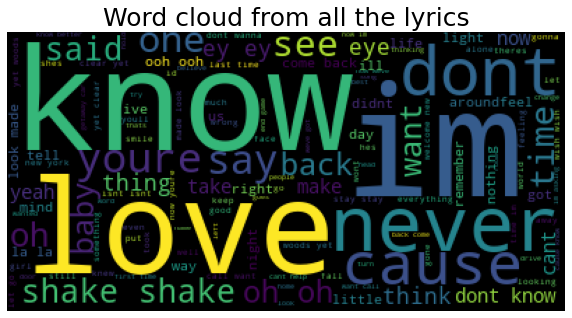

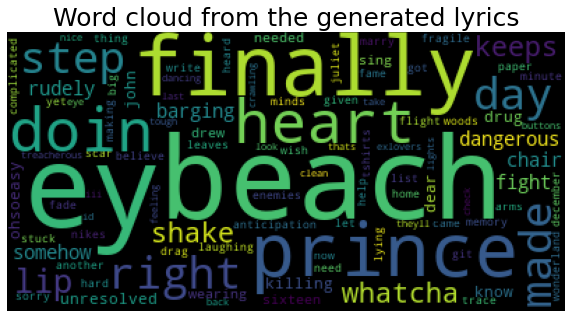

In [0]:
# combine all the generated lyrics into a string, and feed it into the wordcloud generate function
wc1 = WordCloud().generate(raw_text)
wc2 = WordCloud().generate(','.join(l for l in outputs))

# form the word cloud of the most frequently used words in the lyrics
plt.figure(figsize=(10,30))
plt.title('Word cloud from all the lyrics', fontsize=25)
plt.imshow(wc1)
plt.axis("off") # added to not display the x and y axis
plt.show()
plt.figure(figsize=(10,30))
plt.title('Word cloud from the generated lyrics', fontsize=25)
plt.imshow(wc2)
plt.axis("off") # added to not display the x and y axis
plt.show()

### Rhyme score (RS)
- Now our aim is to give a score to list of the last 2 unique charactes list we formed earlier. This is done in order to give closer score to the words which end with the same syllable sound.

- To calculate the value for the index position, we are using the formula:
                [Index position of the 2 charcaters in the list] / [Total length of the list]


In [0]:
!pip install pronouncing
!pip install pywsd
!pip install syllables

     |████████████████████████████████| 942kB 7.6MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6223 sha256=a854cecaf7821a921c0ab08f605b63e212f31233a6836961bc344b3c0ee3a00d
  Stored in directory: /root/.cache/pip/wheels/81/fd/e8/fb1a226f707c7e20dbed4c43f81b819d279ffd3b0e2f06ee13
Successfully built pronouncing
     |████████████████████████████████| 26.8MB 7.9MB/s 
     |████████████████████████████████| 31.6MB 109kB/s 
  Created wheel for pywsd: filename=pywsd-1.2.4-cp36-none-any.whl size=26940453 sha256=094bad4074970167f478dc262fa39437992a81ab19d0ab20cb9ff6f8314c793c
  Stored in directory: /root/.cache/pip/wheels/71/4d/d2/405b948047f7f3851f16ab9d893ce7c1a3010182900884536b
  Created wheel for wn: filename=wn-0.0.23-cp36-none-any.whl size=31792943 sha256=c6898403be9097e3865f02c3c5f3092760ad3f5a436f61b3882f91373e79a040
  Stored in directory: /root/.cache/pip/wheels/56/e3/c4/886021dbf4d758dc3cb9ddaa47d7d6fc895240d83f010e6305
Successfully built 

In [0]:
def rhyming_list_all(bars):
    rhyme_list_all = []
    rhyming_list_final = []
    for bar in bars:
        # taking the last word in each bar
        last_word = re.sub(r"\W+", '', bar.split(" ")[-1]).lower()
        # finding the rhyming word for 'last_word'
        rhyming_words = pronouncing.rhymes(last_word)
        rhyming_words_ending = []
        for rhyming_word in rhyming_words:
            rhyming_words_ending.append(rhyming_word[-2:]) # this will pull the last 2 characters from each rhyming word
        # now we see that which of the 2 characters in the rhyming_words_ending list occur the most
        # we used a try except to capture rythme character, if rhyme character is not found, we take the last 2 characters of the original word
        try:
            rhyming_words_ending_most_common = max(set(rhyming_words_ending), key = rhyming_words_ending.count)
        except Exception:
            rhyming_words_ending_most_common = last_word[-2:]
        rhyme_list_all.append(rhyming_words_ending_most_common)
    # now take the set of rythme to obtain unique last 2 characters
    rhyme_list_all = list(set(rhyme_list_all))
    reverse_list = [x[::-1] for x in rhyme_list_all] #  use slicing syntax to reverse the letters[start,stop,step],
    reverse_list = sorted(reverse_list) # sort the characters
    # now we reverse the string again, so that words with similar sounds can be taken in order
    rhyming_list_final =  [x[::-1] for x in reverse_list]
    return rhyming_list_final

In [0]:
rhyming_list_final = rhyming_list_all(outputs) # contain the list of all common rhyming words (last 2 characters) used in the lyrics across all bars
rhyming_list_final

[]

In [0]:
# we are doing the following steps to see that how close the rhyming words are each other
# This will make the last words which are similar in rhyme to get closer scores

def index_rhyming_word_to_float(rhyming_list_final, bar):
    word = re.sub(r"\W+", '', bar.split(" ")[-1]).lower()
    rhymeslist = pronouncing.rhymes(word)
    rhymeslistends = []
    for i in rhymeslist:
        rhymeslistends.append(i[-2:])
    try:
        rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
    except Exception:
        rhymescheme = word[-2:]
    try:
        float_rhyme = rhyming_list_final.index(rhymescheme)
        float_rhyme = float_rhyme / float(len(rhyming_list_final))
        float_rhyme = round(float_rhyme,3)
        return float_rhyme
    except Exception:
        return 0

### Average syllables (AS)
- We are considering the maximun number of syllables for out rap song to be the average number of syllables across each bar in bars
                     Average syllables = [sum of syllables across each bar] / [total number of bar] 

In [0]:
syllable_list_bar = []
def find_syllables_count(bar):
    syllable_list_bar.append(syllables.estimate(bar))
    estimate = syllables.estimate(bar)/12 # average syllables count in a bar
    estimate = round(estimate,3)
    return estimate

In [0]:
input_values = []
for bar in inputs:
    data_with_value = [bar, find_syllables_count(bar), index_rhyming_word_to_float(rhyming_list_final, bar)]
    input_values.append(data_with_value)

output_values = []
for bar in outputs:
    data_with_value = [bar, find_syllables_count(bar), index_rhyming_word_to_float(rhyming_list_final, bar)]
    output_values.append(data_with_value)

In [0]:
input_values

[]

In [0]:
output_values

[]

### Jaccard Similarity

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. 

It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations. 

In [0]:
def get_jaccard_sim(text1, text2): 
    a = set(text1.split()) 
    b = set(text2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [0]:
print('Jaccard similarity is: ', get_jaccard_sim(' '.join(inputs), ' '.join(outputs)))

Jaccard similarity is:  0.19047619047619047


### Cosine similarity

Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. With cosine similarity, we need to convert sentences into vectors. One way to do that is to use bag of words with either TF (term frequency) or TF-IDF (term frequency- inverse document frequency).

TF is good for text similarity in general, but TF-IDF is good for search query relevance.

In [0]:
word_list1 = nltk.word_tokenize(' '.join(inputs))
lemmatized_output1 = ' '.join([lmm.lemmatize(w) for w in word_list1])
word_list2 = nltk.word_tokenize(' '.join(outputs))
lemmatized_output2 = ' '.join([lmm.lemmatize(w) for w in word_list2])

In [0]:
vectorizer = TfidfVectorizer(stop_words='english')
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]
print(cosine_sim(lemmatized_output1, lemmatized_output2))

tf = vectorizer.fit_transform([lemmatized_output1, lemmatized_output2])
similarity_matrix = cosine_similarity(tf)
print(similarity_matrix)

0.1936616565627426
[[1.         0.19366166]
 [0.19366166 1.        ]]


### Bleu Score

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

In [0]:
b = ' '.join(inputs).split(' ')
a = ' '.join(outputs).split(' ')
score = sentence_bleu(a, b)
print(score)

0.3882726777522233


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


# Mixed Model(LSTM & Markov Chain) to Produce Rhyme

## Use re module to preprocess data

In [0]:
# path = '/content/drive/My Drive/CIS522/Final projection/Deep-Learning-Rap-Lyrics-genrator-master/Data/All_Rap_lyrics.txt'
path = '/content/drive/My Drive/CIS522 Homeworks/Project - Lyrics generation/Deep-Learning-Rap-Lyrics-genrator-master/Data/All_Rap_lyrics.txt'
rap_song_file = open(path,'r', encoding='utf-8').read()
bars = rap_song_file.split('\n')
len(bars)

28983

In [0]:
def re_preprocess(bars):
  # remove all words within '[any words with any size(can be None)]' 
  # remove all lyrics 'Not starting with A-Z, a-z, or whitespace(except '\n')'
  new_bars = []
  for bar in bars:
    bar = re.sub(r'\[.*?\]', '', bar)
    bar = re.sub('[^A-Za-z\s]+', '', bar)
    new_bars.append(bar.strip().lower())
  new_bars = list(filter(None, new_bars))

  # remove lines with less than 4 words
  for i, bar in enumerate(new_bars):
    count_words = len(re.findall('\w+', bar))
    if count_words < 4: del new_bars[i]
  return new_bars

In [0]:
bars = re_preprocess(bars)
print('length of bars: ', len(bars))

length of bars:  21386


In [0]:
rhyming_list_final = rhyming_list_all(bars)

In [0]:
data_set = []
for bar in bars:
    values_set = [bar, find_syllables_count(bar), index_rhyming_word_to_float(rhyming_list_final, bar)]
    data_set.append(values_set)
len(data_set)

21386

In [0]:
X, y = [], []
i = 0
for data in range(len(data_set) - 3):    
    # this would create feature and labels as follows:
    # for example: if features ==> line 1, line 2, then labels ==> line 3, line 4
    # if features ==>  line 2, line 3, then labels ==> line4, line 5
    
    bar_1 = data_set[data][1:]
    bar_2 = data_set[data + 1][1:]
    bar_3 = data_set[data + 2][1:]
    bar_4 = data_set[data + 3][1:]       

    feature = [bar_1[0], bar_1[1], bar_2[0], bar_2[1]]
    label = [bar_3[0], bar_3[1], bar_4[0], bar_4[1]]

    feature = np.array(feature)
    label = np.array(label)
   
    feature = feature.reshape(2,2)
    label = label.reshape(2,2)
 
    X.append(feature)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.3)
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).float())
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [0]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, batch_size, output_dim, num_layers):
    super(LSTM, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim 
    self.batch_size = batch_size
    self.output_dim = output_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout=0.2)
    self.fc = nn.Linear(self.hidden_dim, self.output_dim)

  def forward(self, x):
    x = x.view(1, -1, self.input_dim)
    output, hidden = self.lstm(x)
    hidden = hidden[0] + hidden[1]
    fc_output = self.fc(hidden)
    prediction = fc_output[0] + fc_output[1]
    return prediction

In [0]:
input_dim, hidden_dim, batch_size, output_dim, num_layers = 2*2, 2*4, 100, 2*2, 3
model = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_layers)
model

LSTM(
  (lstm): LSTM(4, 8, num_layers=3, dropout=0.2)
  (fc): Linear(in_features=8, out_features=4, bias=True)
)

In [0]:
lr = 0.001
epochs = 60
input_dim, hidden_dim, batch_size, output_dim, num_layers = 2*2, 2*4, 100, 2*2, 3
model = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
training_loss = np.zeros(epochs)
for epoch in range(epochs):
  Loss = 0
  total = 0
  step = 0
  for i,(data,label) in enumerate(train_loader):
    if data.shape[0] != batch_size: break
    optimizer.zero_grad()
    output = model(data.view(-1, 4, 1))
    loss = criterion(output.view(-1, 2, 2), label)
    loss.backward()
    optimizer.step()

    Loss += loss.item()
    total += label.size(0)
    step += 1

    if step % 100 == 0:
      print('Step|Epoch: [{}|{}], Training loss: {:.4f}'.format(step, epoch+1, loss.item()))
  training_loss[epoch] = Loss/total 

Step|Epoch: [100|1], Training loss: 0.2990
Step|Epoch: [100|2], Training loss: 0.2084
Step|Epoch: [100|3], Training loss: 0.1310
Step|Epoch: [100|4], Training loss: 0.1220
Step|Epoch: [100|5], Training loss: 0.0967
Step|Epoch: [100|6], Training loss: 0.0914
Step|Epoch: [100|7], Training loss: 0.0820
Step|Epoch: [100|8], Training loss: 0.0854
Step|Epoch: [100|9], Training loss: 0.0688
Step|Epoch: [100|10], Training loss: 0.0802
Step|Epoch: [100|11], Training loss: 0.0908
Step|Epoch: [100|12], Training loss: 0.0918
Step|Epoch: [100|13], Training loss: 0.0844
Step|Epoch: [100|14], Training loss: 0.0851
Step|Epoch: [100|15], Training loss: 0.0777
Step|Epoch: [100|16], Training loss: 0.0834
Step|Epoch: [100|17], Training loss: 0.0818
Step|Epoch: [100|18], Training loss: 0.0880
Step|Epoch: [100|19], Training loss: 0.0877
Step|Epoch: [100|20], Training loss: 0.0857
Step|Epoch: [100|21], Training loss: 0.0917
Step|Epoch: [100|22], Training loss: 0.0756
Step|Epoch: [100|23], Training loss: 0.07

## Markov
<b> Step 1 : Creating new senetences using Markov chain </b> 

A Markov chain algorithm basically determines the next most probable suffix word for a given prefix.
To do this, a Markov chain program typically breaks an input text (training text) into a series of words, then by sliding along them in some fixed sized window, storing the first N words as a prefix and then the N + 1 word as a member of a set to choose from randomly for the suffix
The bigger the training text, the better the results.
The step is carried out to create new sentences which could be the part of the new lyrics

<b> Step 2 : We will generate new lyrics using markov chain by creating a markov_text object, which would be used to make sentences later. </b>
Markovify is a simple, extensible Markov chain generator. Right now, its primary use is for building Markov models of large corpora of text and generating random sentences from that. (https://github.com/jsvine/markovify)

In [0]:
raw_file = dataset['lyric'].values.tolist()
raw_file = re_preprocess(raw_file)
str_file = '\n'.join(raw_file)
print(str_file)

he said the way my blue eyes shined
put those georgia stars to shame that night
i said thats a lie
just a boy in a chevy truck
that had a tendency of gettin stuck
on backroads at night
and i was right there beside him all summer long
and then the time we woke up to find that summer gone
but when you think tim mcgraw
i hope you think my favorite song
the one we danced to all night long
the moon like a spotlight on the lake
when you think happiness
i hope you think that little black dress
think of my head on your chest
and my old faded blue jeans
when you think tim mcgraw
i hope you think of me
september saw a month of tears
and thankin god that you werent here
to see me like that
but in a box beneath my bed
is a letter that you never read
from three summers back
its hard not to find it all a little bittersweet
and lookin back on all of that its nice to believe
when you think tim mcgraw
i hope you think my favorite song
the one we danced to all night long
the moon like a spotlight on the

In [0]:
words_count = word_tokenize(str_file)
print('All the words in the bars : ' , len(words_count))
print('All the unique words in the bars : ' , len(set(words_count)))
print('The total number of bar : ', len(bars))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
All the words in the bars :  34621
All the unique words in the bars :  2351
The total number of bar :  21386


In [0]:
!pip install markovify

In [0]:
markov_text = markovify.NewlineText(str_file)

In [0]:
def get_last_word(bar):
    last_word = bar.split(" ")[-1]
    # if the last word is punctuation, get the word before it
    if last_word[-1] in "!.?,":
        last_word = last_word[:-1]
    return last_word
def generate_lyrics():
    bars_new_lyrics = []
    last_words = []
    lyriclength = len(bars)
    count = 0

    while len(bars_new_lyrics) < lyriclength / 9:
        bar = markov_text.make_sentence()
        if type(bar) != type(None) and find_syllables_count(bar) < 1:
            # function to get the last word of the bar
            def get_last_word(bar):
                last_word = bar.split(" ")[-1]
                # if the last word is punctuation, get the word before it
                if last_word[-1] in "!.?,":
                    last_word = last_word[:-1]
                return last_word

            last_word = get_last_word(bar)
            # only use the bar if it is unique and the last_word
            # has only been seen less than 3 times
            if bar not in bars_new_lyrics and last_words.count(last_word) < 3:
                bars_new_lyrics.append(bar)
                last_words.append(last_word)
                count += 1

    return bars_new_lyrics

In [0]:
bars_new_lyrics = generate_lyrics()

In [0]:
bars_new_lyrics[0:10] # sample of some sentence created using markov chain

['and my hand and',
 'i hope you know why',
 'i reached for you to walk in',
 'i knew you were mine',
 'and baby ive got my big coat on',
 'and you call me lately',
 'you take the road',
 'i said we should be marrying the wrong girl',
 'youre still on the floor wont fall through again',
 'light up when youre gone']

In [0]:
print('Length of the newly generated bar using markov chain : ' , len(bars_new_lyrics))

Length of the newly generated bar using markov chain :  2377


In [0]:
# repeating the same process to find the list of rhyming characters and creating a list
rhyming_list_final_new_lyrics = rhyming_list_all(bars_new_lyrics)

In [0]:
rhyming_list_final_new_lyrics[:10] # some of the rhyming characters

["s'", 'aa', 'ea', 'ma', 'oa', 'ya', 'ub', 'ic', 'ad', 'ed']

In [0]:
print(len(rhyming_list_final_new_lyrics))

135


<b>  Step 3 : Making prediction for the next lines to be considered for generating new rap songs </b> 
- The step is carried out to select any random index to start from the original lyrics
- Then selecting the next line to the randonly selected index
- Passing these inputs in the model and getting the prediction
- Using the prediction and passing it to the model to get new prediction
- This process is repeated to the length of the lyrics we want to achieve

In [0]:
model.eval()
def predicting_lyrics(rhyming_list_final_new_lyrics, model):
    rap_lyrics_numeric_predictions = []
    start_lines = []    

    # random index to start
    initial_index = random.choice(range(len(bars) - 1))
    # choosing the next 2 lines corresponding to the index
    initial_lines = bars[initial_index:initial_index + 2]
    
    for line in initial_lines:
        start_lines.append([find_syllables_count(line), index_rhyming_word_to_float(rhyming_list_final,line)])
    
    # using the above selected lines to predict the output
    start_lines = np.array([start_lines]).reshape(1,4,1)
    temp = torch.tensor(start_lines).float()
    start_lyrics_numeric_predictions = model(temp)
    rap_lyrics_numeric_predictions.append(start_lyrics_numeric_predictions.reshape(1,2,2))
    
    # using the output of the model recursievely to find the new output, here range 50 is taken as we want out lyrics to be of length 50
    for i in range(50):
        rap_lyrics_numeric_predictions_input = rap_lyrics_numeric_predictions[-1].reshape(1,4,1)#np.array([rap_lyrics_numeric_predictions[-1]]).reshape(1, 2, 2)
        temp1=model(rap_lyrics_numeric_predictions_input).reshape(1,2,2)
        rap_lyrics_numeric_predictions.append(temp1)
    return rap_lyrics_numeric_predictions

In [0]:
rap_generated_with_prediction = predicting_lyrics(rhyming_list_final, model)

In [0]:
for i in range(len(rap_generated_with_prediction)):
  rap_generated_with_prediction[i] = rap_generated_with_prediction[i].detach().numpy()

<b> Step 4 : Making prediction for the next lines to be considered for generating new rap songs </b> 
- The step is carried out to assign every new lyrics bar with 2 values:
                            1. average syllable count
                            2. Float value of the index position


In [0]:
dataset_new_lyrics = []
for line in bars_new_lyrics:
    line_list = [line, find_syllables_count(line), index_rhyming_word_to_float(rhyming_list_final_new_lyrics,line)]
    dataset_new_lyrics.append(line_list)
dataset_new_lyrics

[['and my hand and', 0.333, 0.089],
 ['i hope you know why', 0.5, 0.333],
 ['i reached for you to walk in', 0.667, 0.519],
 ['i knew you were mine', 0.583, 0.2],
 ['and baby ive got my big coat on', 0.833, 0.504],
 ['and you call me lately', 0.583, 0.919],
 ['you take the road', 0.417, 0.133],
 ['i said we should be marrying the wrong girl', 0.833, 0.43],
 ['youre still on the floor wont fall through again', 0.917, 0.511],
 ['light up when youre gone', 0.583, 0.526],
 ['she dont even know her', 0.5, 0.615],
 ['last time i say hopelessly', 0.75, 0.919],
 ['dressed like a tragedy now', 0.75, 0.556],
 ['and now that its delicate', 0.667, 0.23],
 ['you take my time', 0.5, 0.193],
 ['im in a crowded room', 0.5, 0.193],
 ['and i know places', 0.417, 0.652],
 ['they are the kings and the note that said', 0.917, 0.067],
 ['lipstick on your chest', 0.417, 0.815],
 ['and pull me in', 0.333, 0.519],
 ['cause these things happen', 0.583, 0.511],
 ['the moon like a scared little boy', 0.833, 0.933]

In [0]:
# seperating the lines predicted into multiple line. 
#As we know that the data we have is in the shape(2x2) but we need to change it to (#1x1) so each line can be taken in account
rap_bars = []
for raps in rap_generated_with_prediction:
    rap_bars.append(list(raps[0][0]))
    rap_bars.append(list(raps[0][1]))

<b> Step 5 : Comapring the newly generated lyrics with predicted output </b> 

In [0]:
# we are doing this to penalise the new sentences whose last word matches with the already existing last word in the newly predicted rap
# the step is necessary so that the sentence with same ending words are not selected twice

def comparing_last_words_bars(rap, line2):
    additional_penalising = 0
    for line1 in rap:
        last_word_rap = line1.split(" ")[-1] # last word selected in rap
        last_word_new_lyrics = line2.split(" ")[-1] # last word in each item of data_set_new_lyrics
        if last_word_rap == last_word_new_lyrics:
            additional_penalising += .2 # penalty could be any, but here we will penalize the value by 2

    return additional_penalising

# vector_half is a single [syllable, rhyme_index] pair
# returns a score rating for a given line
def calculate_score(vector_half, syllables, rhyme, penalty):
    desired_syllables = vector_half[0]
    desired_rhyme = vector_half[1]
    syllables = syllables * 12
    rhyme = rhyme * len(rhyming_list_final_new_lyrics)
    desired_syllables = desired_syllables * 12
    desired_rhyme = desired_rhyme * len(rhyming_list_final)

    score = (abs((float(desired_syllables) + float(syllables) + float(desired_rhyme) + float(rhyme)))) - penalty

    return score


In [0]:
def song_generation(rap_generated_with_prediction, bars_new_lyrics, rhyming_list_final_new_lyrics):
     # generated a list of all the lines from generated_lyrics with their
    # line, syllables, and rhyme float value
    rap = []
    for rap_bar in rap_bars:
        # The bar in the predicted bars is scored against every generated bar
        scorelist = []
        for item in dataset_new_lyrics:
            # item is one of the generated bars from the Markov model
            line = item[0] 
            if len(rap) != 0:
                penalty = comparing_last_words_bars(rap, line)
            else:
                penalty = 0
            # calculate the score of the current line
            total_score = calculate_score(rap_bar, item[1], item[2], penalty)
            score_entry = [line, total_score]
            # add the score of the current line to a scorelist
            scorelist.append(score_entry)

        fixed_score_list = []
        for score in scorelist:
            fixed_score_list.append(float(score[1]))
        
        # Highest score of the bar of newly generated lyrics is taken as a match to what is predicted by the model. 
        max_score = max(fixed_score_list)
        for score in scorelist:
            if score[1] == max_score:
                rap.append(score[0])
                for data in dataset_new_lyrics:
                    if item[0] == data[0]:
                        dataset_new_lyrics.remove(data)# removing the bar which has been added to our final list
                        break
                break
    return rap


In [0]:
rap_song_generated = song_generation(rap_generated_with_prediction, bars_new_lyrics, rhyming_list_final_new_lyrics)

In [0]:
from termcolor import colored
print(colored('============================= OUR RAP SONG =============================', 'red'))
for rap in rap_song_generated:
    print(colored(rap, 'blue'))

============================= OUR RAP SONG =============================
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
you should think you should see the things that she does
walking with his head down trying to look busy
you should think you should see the things that she does
walking with his head down trying to look busy
you should think you should see the things that she does
walking with his head down trying to look busy
you should think you should see the things th

In [0]:
#After training
Taylor_style_rap = []
for line in rap_song_generated:
    line_list = [line, find_syllables_count(line), index_rhyming_word_to_float(rhyming_list_final_new_lyrics,line)]
    Taylor_style_rap.append(line_list)
Taylor_style_rap

[['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['walking with his head down trying to look busy', 0.917, 0.978],
 ['you should think you should see the things that she does', 0.917, 0.993],
 ['walkin

## Evaluation of the results

                            Evaluation creiteria chosen:
                            1. Jaccard Similarity
                            2. Cosine Similarity
                            3. Bleu Score

<b> Method 1 : Jaccard Similarity </b>

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. 

It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations. 

In [0]:
def get_jaccard_sim(text1, text2): 
    a = set(text1.split()) 
    b = set(text2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [0]:
generated_str_file = ''
for data in rap_song_generated:
  generated_str_file += data
  generated_str_file += '\n'
generated_str_file = generated_str_file[:-2]

In [0]:
print('Jaccard similarity is: ', get_jaccard_sim(str_file,generated_str_file))

Jaccard similarity is:  0.022949426264343393


<b> Method 2 : Cosine similarity </b> <br>

Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. With cosine similarity, we need to convert sentences into vectors. One way to do that is to use bag of words with either TF (term frequency) or TF-IDF (term frequency- inverse document frequency).

TF is good for text similarity in general, but TF-IDF is good for search query relevance.

In [0]:
word_list1 = nltk.word_tokenize(str_file)
lemmatized_output1 = ' '.join([lmm.lemmatize(w) for w in word_list1])
word_list2 = nltk.word_tokenize(generated_str_file)
lemmatized_output2 = ' '.join([lmm.lemmatize(w) for w in word_list2])

In [0]:
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [0]:
print(cosine_sim(lemmatized_output1, lemmatized_output2))
tf = vectorizer.fit_transform([lemmatized_output1, lemmatized_output2])
similarity_matrix = cosine_similarity(tf)
print(similarity_matrix)

0.17608442793579815
[[1.         0.17608443]
 [0.17608443 1.        ]]


<b> Method 3 : Bleu Score</b>

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

In [0]:
b = str_file.split(' ')
a = generated_str_file.split(' ')
score = sentence_bleu(a, b)
print(score)

0.1189872017327475


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


<hr>

## REFERENCES

We have referred and went through several different articles, journals and github repository in order to approach the question for rap lyrics generation. The idea has mainly been adapted by the below two Journal articles where the use of Markov chain and LSTM has been done to ahieve the output. From github we have adapted the idea to strcutre the code.Below are the list of references 

<b>Journal articles </b>

Potash, P., Romanov, A. and Rumshisky, A. (2015). GhostWriter: Using an LSTM for Automatic Rap Lyric Generation. Dept of Computer SCience. University of Massachusetts Lowell. http://www.emnlp2015.org/proceedings/EMNLP/pdf/EMNLP221.pdf
<br>
<br>
Potash, P., Romanov, A. and Rumshisky, A. (2015). Evaluating Creative Language Generation: The Case of Rap Lyric Ghostwriting. Dept. of Computer Science. University of Massachusetts Lowell. https://www.aclweb.org/anthology/W18-1604


<b> GitHub Repository </b> 

https://github.com/llSourcell/Rap_Lyric_Generator<br>
https://github.com/robbiebarrat/rapping-neural-network

<b> Online articles </b>

https://colah.github.io/posts/2015-08-Understanding-LSTMs<br>
https://towardsdatascience.com/ai-generates-taylor-swifts-song-lyrics-6fd92a03ef7e<br>
https://towardsdatascience.com/using-a-markov-chain-sentence-generator-in-python-to-generate-real-fake-news-e9c904e967e


